# 🛒 Walmart Shelf Monitor (Google Colab Version)
This notebook lets you upload a shelf image, run YOLOv8 detection, and compare the results to a Walmart-style planogram using a pretrained model or your own fine-tuned model.

In [ ]:
# 📦 Install dependencies
!pip install ultralytics opencv-python-headless Pillow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
# 📁 Upload a photo of walmart drink aisle
from google.colab import files
uploaded = files.upload()
from PIL import Image
for fname in uploaded:
    image = Image.open(fname).convert("RGB")
    image_path = fname

Saving 186567776-grovetown-ga-usa-05-20-22-walmart-retail-store-interior-side-view-soda-section.jpg to 186567776-grovetown-ga-usa-05-20-22-walmart-retail-store-interior-side-view-soda-section.jpg


In [ ]:
# 🧠 Load YOLOv8 model
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # Replace with your trained .pt file if needed

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:01<00:00, 4.92MB/s]


In [ ]:
# 🔍 Run detection
results = model(image)
boxes = results[0].boxes
import pandas as pd
df = pd.DataFrame({
    'x1': boxes.xyxy[:, 0].cpu().numpy(),
    'y1': boxes.xyxy[:, 1].cpu().numpy(),
    'x2': boxes.xyxy[:, 2].cpu().numpy(),
    'y2': boxes.xyxy[:, 3].cpu().numpy(),
    'confidence': boxes.conf.cpu().numpy(),
    'class_id': boxes.cls.cpu().numpy().astype(int)
})
class_names = results[0].names
df['name'] = df['class_id'].apply(lambda x: class_names[x])
df[['name', 'confidence']]


0: 480x640 12 bottles, 1 refrigerator, 390.4ms
Speed: 40.6ms preprocess, 390.4ms inference, 35.4ms postprocess per image at shape (1, 3, 480, 640)


,name,confidence
0,bottle,0.723364
1,bottle,0.701797
2,bottle,0.663864
3,bottle,0.593367
4,refrigerator,0.578196
5,bottle,0.526914
6,bottle,0.525117
7,bottle,0.482060
8,bottle,0.455600
9,bottle,0.383261


In [ ]:
# 📋 Load Planogram
import json
planogram = {
    "aisle": "23",
    "expected": [
        {"sku": "bottle", "min_count": 5}
    ]
}

def check_planogram(detections_df, planogram):
    detected = detections_df['name'].value_counts().to_dict()
    issues = []
    for p in planogram['expected']:
        actual = detected.get(p['sku'], 0)
        if actual < p['min_count']:
            issues.append(f"❌ {p['sku']} understocked: {actual}/{p['min_count']}")
        else:
            issues.append(f"✅ {p['sku']} OK: {actual}/{p['min_count']}")
    return issues

planogram_results = check_planogram(df, planogram)
for issue in planogram_results:
    print(issue)

✅ bottle OK: 12/5


In [ ]:
# 📑 Load Walmart Metadata
import io
metadata_csv = '''sku,product_name,brand,category,package_size,price_usd
CocaCola_12pk,Coca-Cola Classic 12-Pack,Coca-Cola,Soda,12pk,6.99
Sprite_12pk,Sprite Lemon Lime 12-Pack,Coca-Cola,Soda,12pk,6.99
Doritos_10oz,Doritos Nacho Cheese 10oz,PepsiCo,Chips,10oz,4.29
Pepsi_12pk,Pepsi Cola 12-Pack,Pepsi,Soda,12pk,6.99
MountainDew_12pk,Mountain Dew 12-Pack,Pepsi,Soda,12pk,6.99
RedBull_4pk,Red Bull Energy Drink 4-Pack,Red Bull,Energy Drink,4pk,7.99
'''
metadata_df = pd.read_csv(io.StringIO(metadata_csv))
metadata_df.head()

,sku,product_name,brand,category,package_size,price_usd
0,CocaCola_12pk,Coca-Cola Classic 12-Pack,Coca-Cola,Soda,12pk,6.99
1,Sprite_12pk,Sprite Lemon Lime 12-Pack,Coca-Cola,Soda,12pk,6.99
2,Doritos_10oz,Doritos Nacho Cheese 10oz,PepsiCo,Chips,10oz,4.29
3,Pepsi_12pk,Pepsi Cola 12-Pack,Pepsi,Soda,12pk,6.99
4,MountainDew_12pk,Mountain Dew 12-Pack,Pepsi,Soda,12pk,6.99


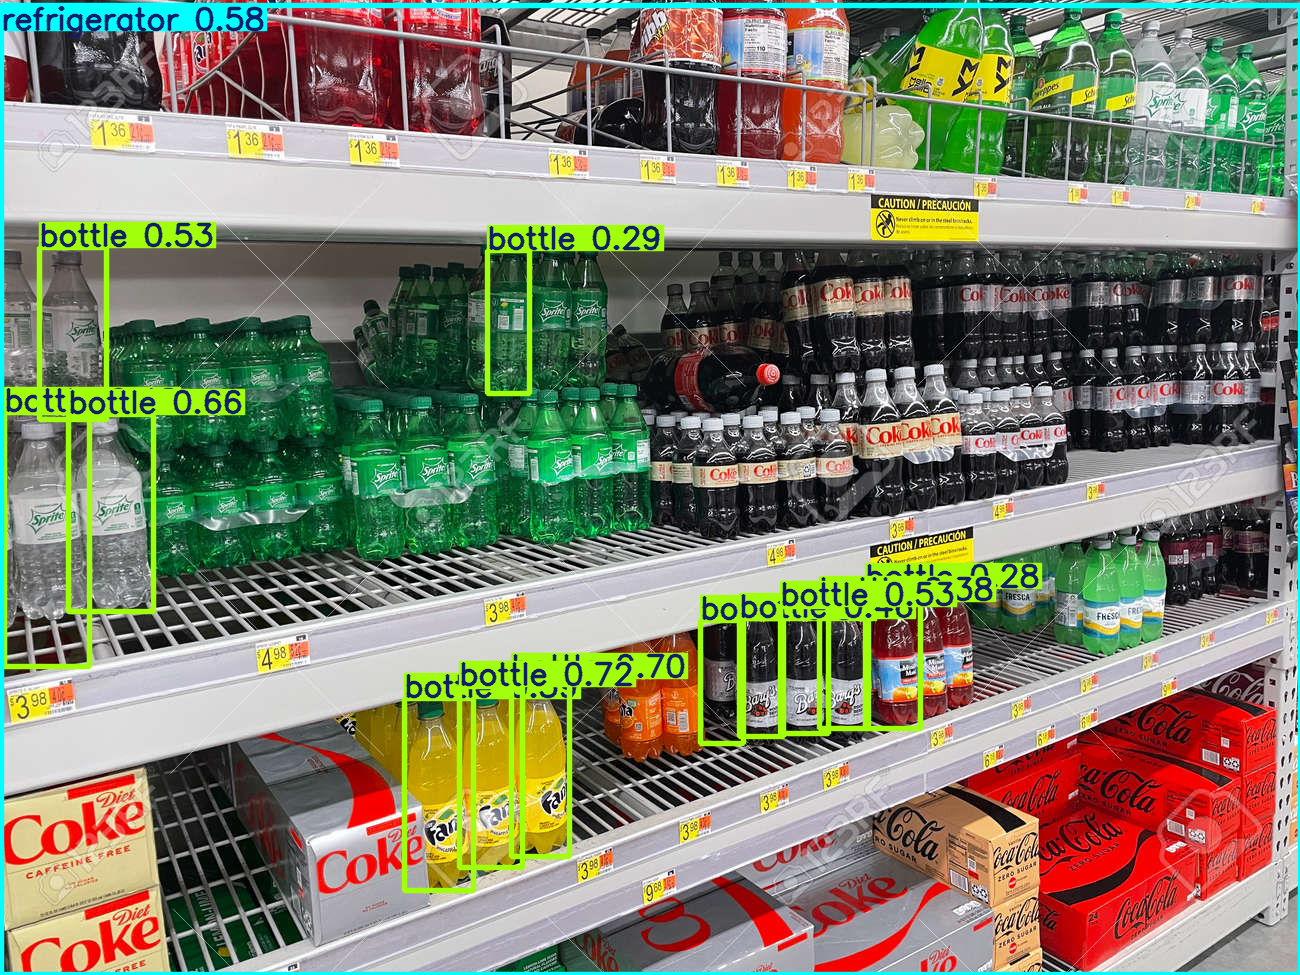

In [ ]:
# 🖼️ Visualize detections
results[0].show()